# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [ ]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("/content/drive/MyDrive/ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [ ]:
def principalComponentAnalysis(X, numComponents):
    #  Compute the mean face by taking the mean along the rows (axis=0) of the data matrix X
    meanFace = np.mean(X, axis=0)

    # Normalize the data by subtracting the mean face from each data point
    X_normalized = X - meanFace

    #  Compute the covariance matrix C using the normalized data
    C = np.dot(X_normalized.T, X_normalized) / X_normalized.shape[0]

    # Perform eigen decomposition on the covariance matrix to obtain eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(C)

    #  Sort eigenvalues in descending order and rearrange corresponding eigenvectors accordingly
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    #  Select the top numComponents eigenvectors as eigenfaces
    eigenFaces = eigenvectors[:, :numComponents]

    #  Normalize each eigenface to have unit length
    for i in range(eigenFaces.shape[1]):
        eigenFaces[:, i] = eigenFaces[:, i] / np.linalg.norm(eigenFaces[:, i])

    # Return eigenfaces, mean face, and eigenvalues
    return eigenFaces, meanFace, eigenvalues

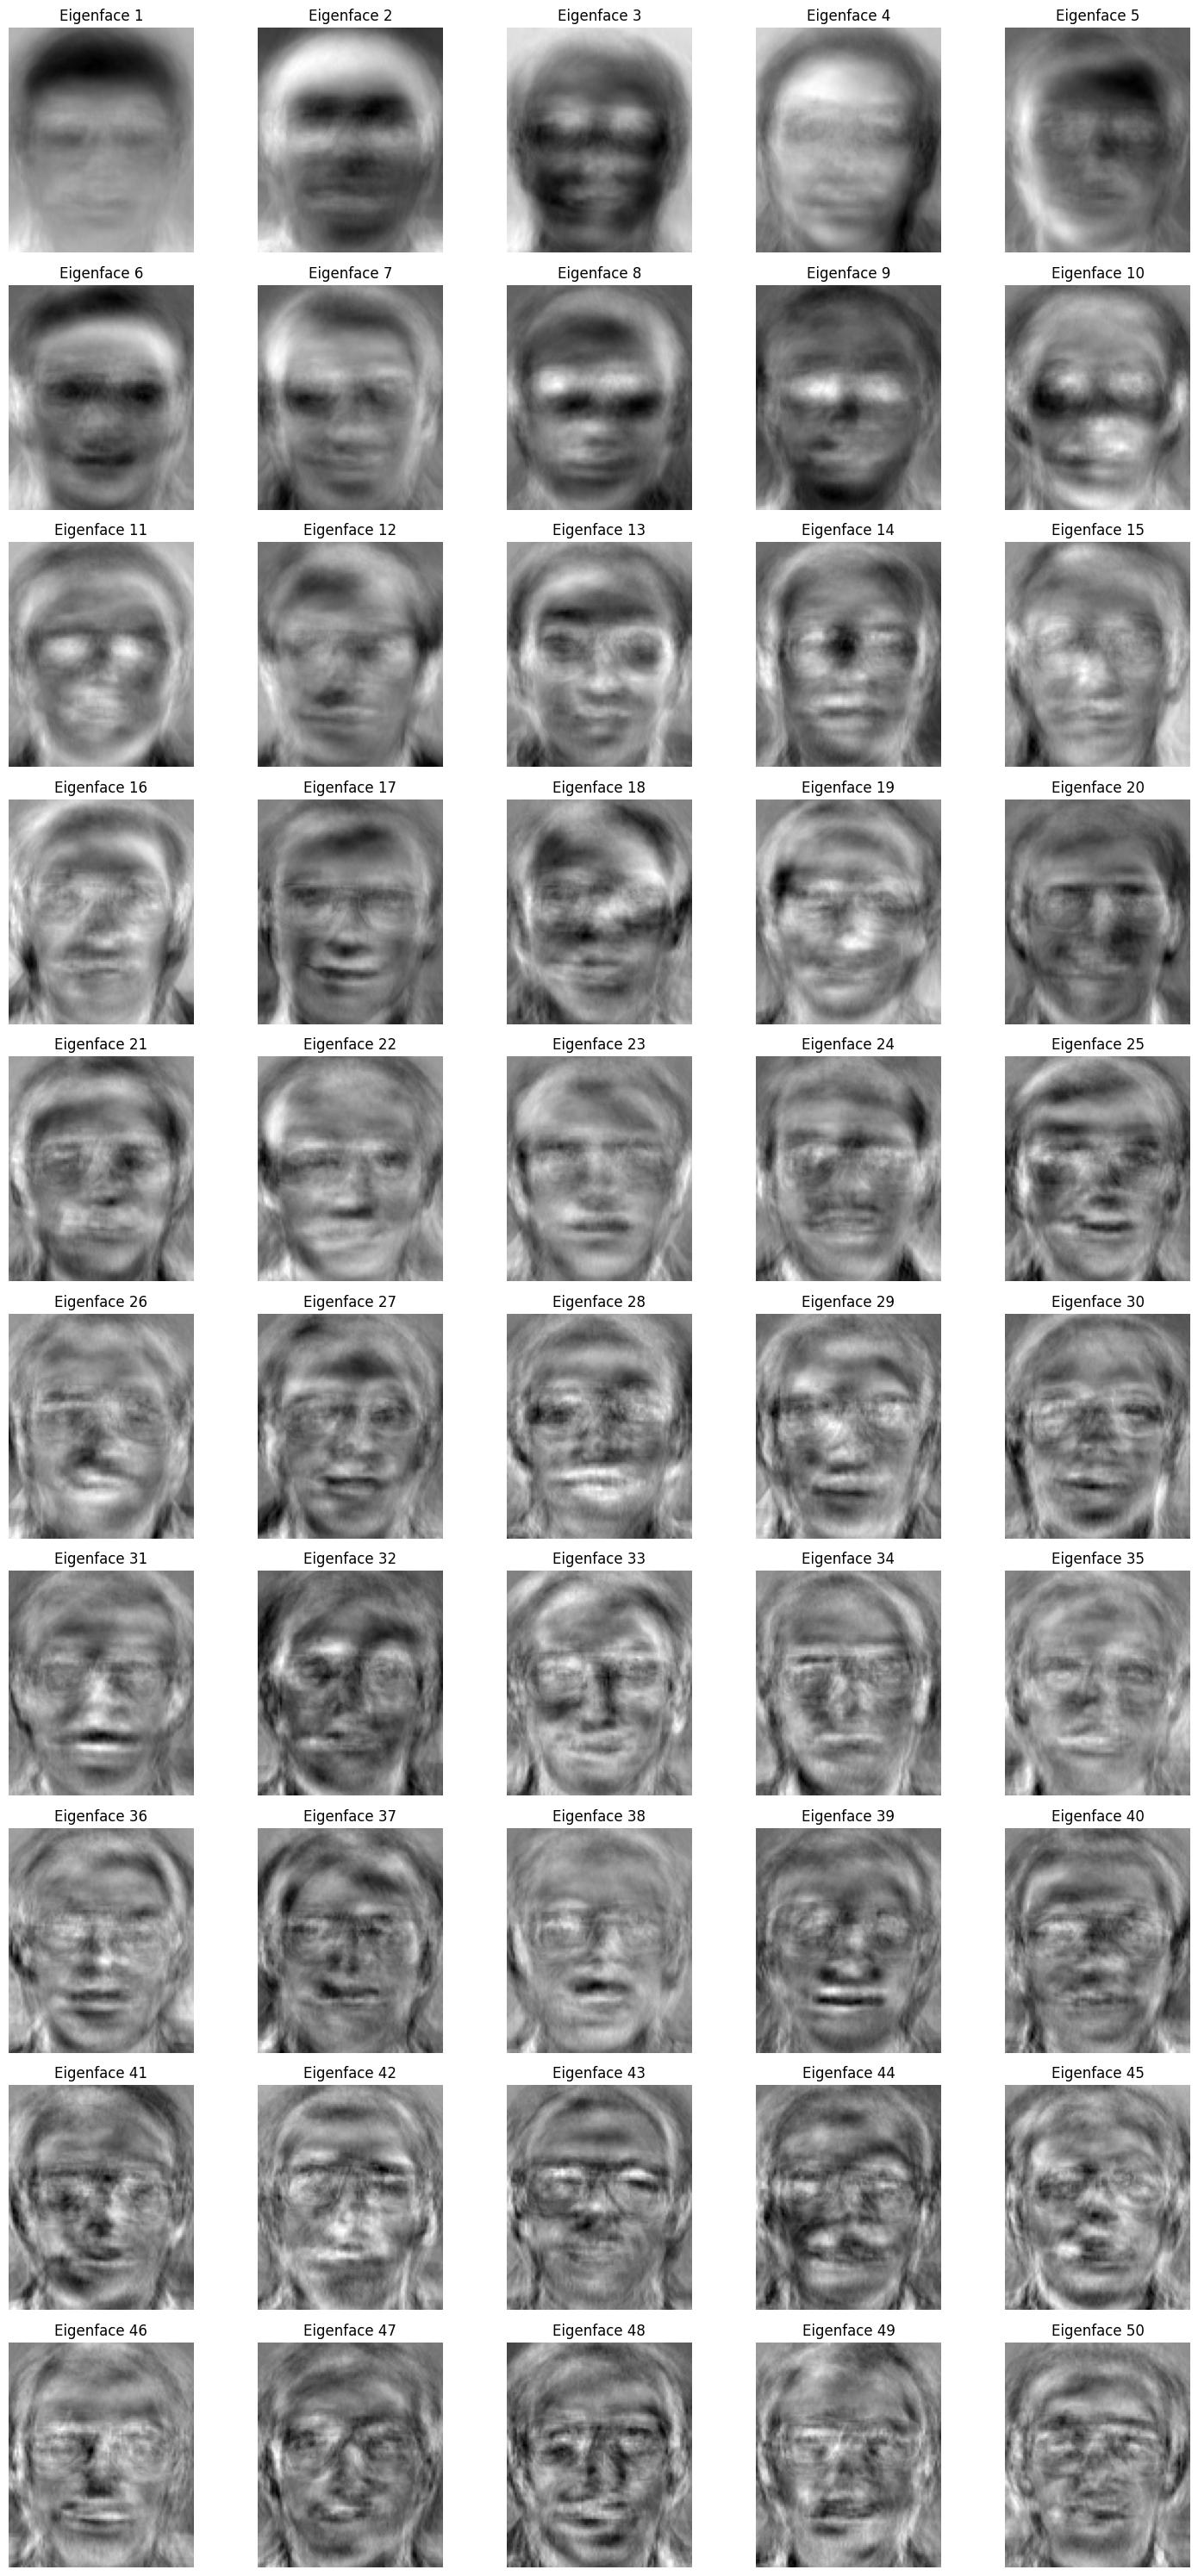

In [ ]:
def plotEigenfaces(eigenvectors, imageSize, numEigenfaces):
    # Ensure the number of eigenfaces to plot does not exceed the total number of available eigenfaces
    numEigenfaces = min(numEigenfaces, eigenvectors.shape[1])

    # Determine the number of columns for subplots (max 5 columns)
    cols = min(numEigenfaces, 5)

    # Calculate the number of rows required based on the number of eigenfaces and columns
    rows = (numEigenfaces + cols - 1) // cols

    # Create a subplot grid with appropriate dimensions
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    # Iterate over each eigenface and plot it
    for i in range(numEigenfaces):
        eigenface = np.real(eigenvectors[:, i]).reshape(imageSize)
        axes[i].imshow(eigenface, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Eigenface {i+1}')

    # Hide axes for unused subplots
    for i in range(numEigenfaces, rows*cols):
        axes[i].axis('off')

    # Adjust layout to prevent overlap of subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
numComponents = 100
X = trainFaces
X_flattened = X.reshape(X.shape[0], -1)
eigenvectors, eigenvalues, meanFace = principalComponentAnalysis(X_flattened, numComponents)
eigenvectors_real = np.real(eigenvectors)
plotEigenfaces(eigenvectors_real, imageSize=(112, 92), numEigenfaces=50)

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

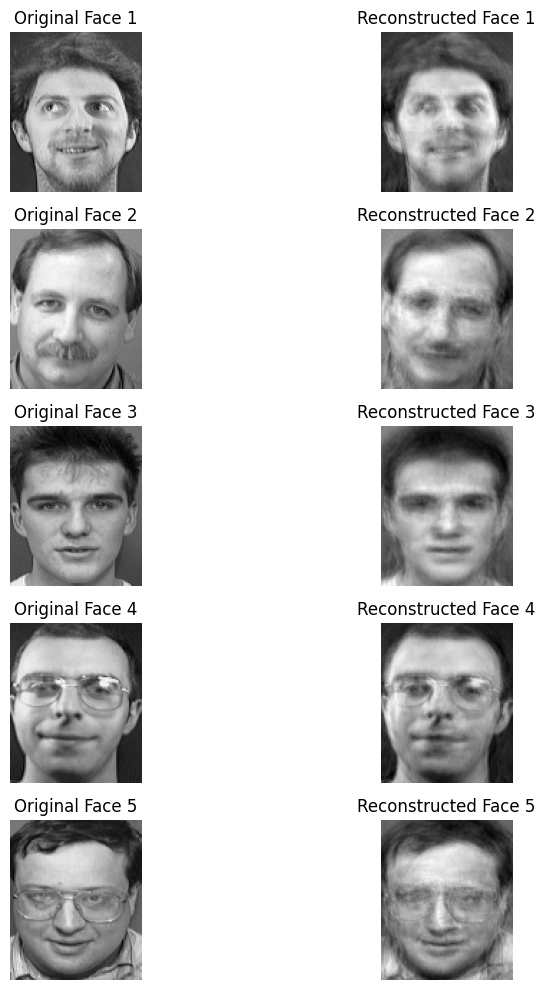

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imageReconstruction(testFace, eigenFaces, meanFace):
    #  Center the test face by subtracting the mean face
    centeredFace = testFace - meanFace

    #  Compute the weights (coefficients) for each eigenface
    weights = np.dot(eigenFaces.T, centeredFace)

    #  Reconstruct the face using the eigenfaces and weights
    reconstruction = meanFace + np.dot(eigenFaces, weights)

    return reconstruction

#  Flatten the images in the dataset X
X_flattened = X.reshape(X.shape[0], -1)

#  Perform Principal Component Analysis to obtain eigenfaces, mean face, and eigenvalues
eigenFaces, meanFace, eigenvalues = principalComponentAnalysis(X_flattened, numComponents)

#  Display reconstructed faces
num_faces = 5
fig, axes = plt.subplots(num_faces, 2, figsize=(10, 2 * num_faces))

for i in range(num_faces):
    #  Select a test face
    testFace = X_flattened[i, :]

    #  Reconstruct the test face using the defined function
    reconstructedFace = imageReconstruction(testFace, eigenFaces, meanFace)

    #  Display original face
    axes[i, 0].imshow(testFace.reshape(112, 92), cmap='gray')
    axes[i, 0].set_title(f'Original Face {i+1}')
    axes[i, 0].axis('off')

    #  Display reconstructed face
    axes[i, 1].imshow(np.real(reconstructedFace).reshape(112, 92), cmap='gray')
    axes[i, 1].set_title(f'Reconstructed Face {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

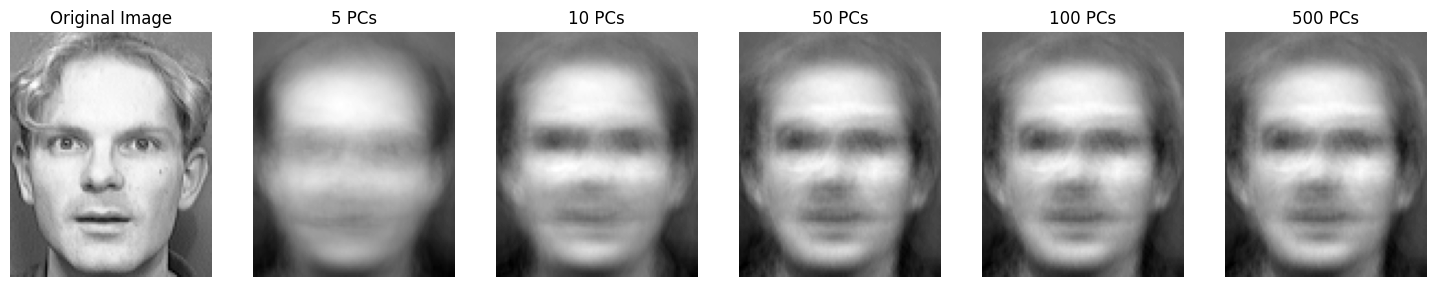

In [ ]:
%matplotlib inline

def displayNfactors(testImage, eigenFaces, meanFace, components):
    plt.figure(figsize=(15, 10))
    numPlots = len(components) + 1
    testImage = np.real(testImage)
    meanFace = np.real(meanFace)
    plt.subplot(1, numPlots, 1)
    plt.imshow(testImage.reshape(112, 92), cmap='gray')  
    plt.title('Original Image')
    plt.axis('off')

    for i, numComponents in enumerate(components, start=2):
        selectedEigenFaces = eigenFaces[:, :numComponents]
        selectedEigenFaces = np.real(selectedEigenFaces)
        weights = np.dot(selectedEigenFaces.T, testImage - meanFace)
        reconstruction = meanFace + np.dot(selectedEigenFaces, weights)
        reconstruction = np.real(reconstruction)
        plt.subplot(1, numPlots, i)
        plt.imshow(reconstruction.reshape(112, 92), cmap='gray')
        plt.title(f'{numComponents} PCs')
        plt.axis('off')
    plt.tight_layout(pad=3.0)
    plt.show()

eigenvectors_real = np.real(eigenvectors)

components = [5, 10, 50, 100,500]

X = testFaces
X_test_flattened = X.reshape(X.shape[0], -1)
singleTestImage = X_test_flattened[0]


displayNfactors(singleTestImage, eigenFaces, meanFace, components=[5, 10, 50, 100,500])

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [ ]:
def projectOntoPCA(testFace, eigenFaces, meanFace):
    #  Center the test face by subtracting the mean face
    centeredFace = testFace - meanFace

    #  Compute the weights (coefficients) for each eigenface
    weights = np.dot(eigenFaces.T, centeredFace)

    return weights

def reconstructFromPCA(weights, eigenFaces, meanFace):
    #  Reconstruct the face using the eigenfaces and weights
    reconstruction = meanFace + np.dot(eigenFaces, weights)

    return reconstruction

def calculateReconstructionError(testFace, reconstructedFace):
    # Calculate the reconstruction error between the original and reconstructed face
    error = np.sum((testFace - reconstructedFace) ** 2)

    return error

def getClass(testFace, eigenFaces, meanFace, X_train, y_train, numComponents):
    # Project test face onto PCA subspace and find the class with the smallest reconstruction error
    eigenFaces_selected = eigenFaces[:, :numComponents]
    weights = projectOntoPCA(testFace, eigenFaces_selected, meanFace)
    minError = np.inf
    predClass = None
    imageWithSmallestError = None
    uniqueClasses = np.unique(y_train)
    for cls in uniqueClasses:
        classIndices = np.where(y_train == cls)[0]
        classFaces = X_train[classIndices]
        classWeights = np.mean([projectOntoPCA(face, eigenFaces_selected, meanFace) for face in classFaces], axis=0)
        reconstructedClassFace = reconstructFromPCA(classWeights, eigenFaces_selected, meanFace)
        error = calculateReconstructionError(testFace, reconstructedClassFace)
        if error < minError:
            minError = error
            predClass = cls
            imageWithSmallestError = reconstructedClassFace

    return imageWithSmallestError, minError, predClass

def calculateMSE(testFaces, eigenFaces, meanFace, numComponents, X_train, y_train, y_test):
    #  Calculate Mean Squared Error (MSE) and accuracy for the test faces
    totalError = 0
    correctPredictions = 0
    for i, testFace in enumerate(testFaces):
        _, error, predictedClass = getClass(testFace, eigenFaces, meanFace, X_train, y_train, numComponents)
        totalError += error
        if predictedClass == y_test[i]:
            correctPredictions += 1
    mse = totalError / len(testFaces)
    accuracy = correctPredictions / len(testFaces)

    return mse, accuracy


Iterate through all the images in the test data and test the accuracy by taking different number of components

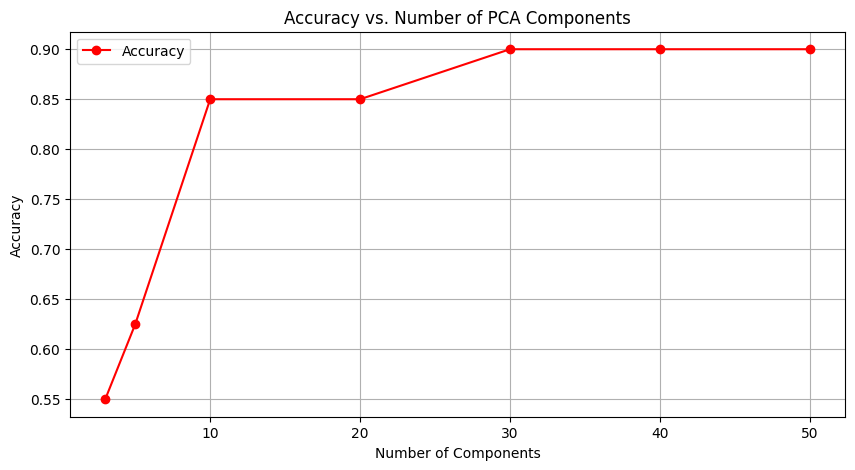

In [ ]:
X_flattened = trainFaces.reshape(trainFaces.shape[0], -1)
X_test_flattened = testFaces.reshape(testFaces.shape[0], -1)
components = [3, 5, 10, 20, 30, 40, 50]
mse = []
accuracies = []
eigenFaces, meanFace, _ = principalComponentAnalysis(X_flattened, max(components))
for numComponents in components:
    currentMSE, currentAccuracy = calculateMSE(X_test_flattened, eigenFaces, meanFace, numComponents, X_flattened, trainLabels, testLabels)
    mse.append(currentMSE)
    accuracies.append(currentAccuracy)
plt.figure(figsize=(10, 5))
plt.plot(components, accuracies, marker='o', color='red', label='Accuracy')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Mean Square Error

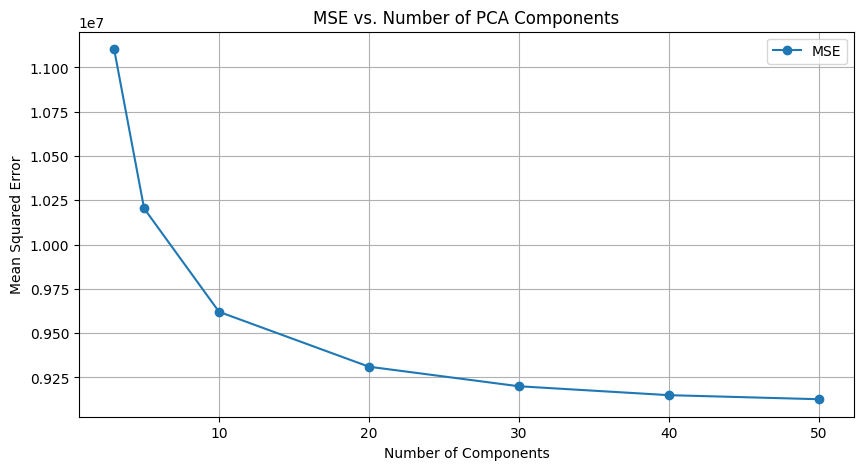

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(components, mse, marker='o', label='MSE')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

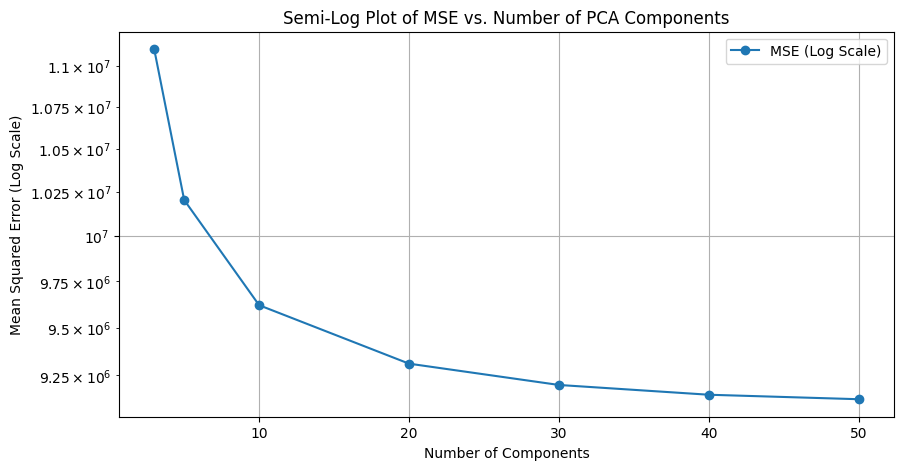

In [ ]:
plt.figure(figsize=(10, 5))
plt.semilogy(components, mse, marker='o', label='MSE (Log Scale)')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (Log Scale)')
plt.title('Semi-Log Plot of MSE vs. Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()